In [2]:
%load_ext autoreload
%autoreload 2

In [103]:
# numeric imports
import torch
import numpy as np
# import models
import gpytorch
from src.models.sparse.gridded_univariate_structure import GriddedMatern12ExactGP, GriddedMatern12SVGP, GriddedMatern12VFFGP, GriddedMatern12ASVGP, Matern12GriddedGP
# plotting imports
import matplotlib.pyplot as plt
# utils imports
from src.utils.datagenerators import gen_1d
from src.utils.integrators import integrate_1d
# misc imports
from tqdm import tqdm

In [124]:
plt.style.use('tableau-colorblind10')

# Generate Data

In [54]:
# latent function
latent_function = lambda x : torch.sin(x) + torch.cos(x)
numpy_latent_function = lambda x : np.sin(x) + np.cos(x)

# meta
LEFTLIM = 0.
RIGHTLIM = 2.
N_OBS = 25

# generate data
X, y = gen_1d(fun = latent_function, leftlim = LEFTLIM, rightlim = RIGHTLIM, nobs = N_OBS, randomspacing = False)

# add noise
y += torch.distributions.Normal(0, 0.05).sample(y.shape)

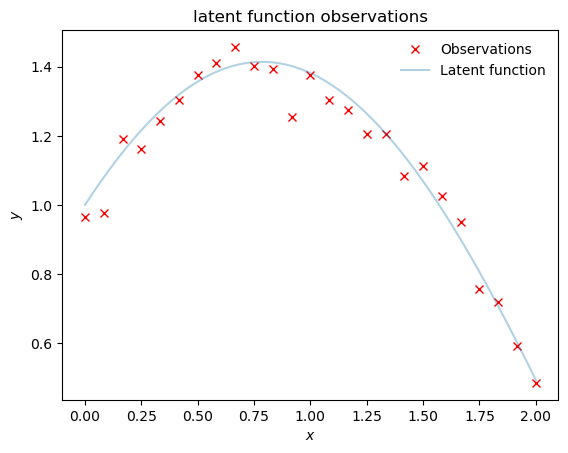

In [29]:
# plot data
plt.plot(X, y, 'x', color = 'red', label = 'Observations')
plt.plot(torch.linspace(LEFTLIM, RIGHTLIM, 1000), latent_function(torch.linspace(LEFTLIM, RIGHTLIM, 1000)), alpha = 0.3, label = 'Latent function') # true function
plt.title('latent function observations')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend(frameon=False)

In [30]:
X_train = X.clone().to(torch.float64)
y_train = y.clone().to(torch.float64)

# GriddedExactGP

In [31]:
exact_gp = GriddedMatern12ExactGP(
                                train_x=X_train, train_y=y_train,
                                n_b0_splines=10,
                                gridlims = (0., 2.))

In [32]:
# fit the Exact GP
EXACT_GP_LR = 0.01
EXACT_GP_ITERATIONS = 1000
# set model and likelihood into training mode
exact_gp.train()
exact_gp.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(exact_gp.parameters(), lr = EXACT_GP_LR)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exact_gp.likelihood, exact_gp)
for i in tqdm(range(EXACT_GP_ITERATIONS)):
    optimizer.zero_grad()
    output = exact_gp(exact_gp.train_x)
    loss = -mll(output, exact_gp.train_y)
    loss.backward()
    optimizer.step()

print('='*((5*15) + 4))
print(f"{'Iteration':^15}|{'Loss':^15}|{'Noise':^15}|{'Lengthscale':^15}|{'Outputscale':^15}")
print('='*((5*15) + 4))
print(f"{i+1:^15}|{loss.item():^15.3f}|{exact_gp.likelihood.noise.item():^15.3f}|{exact_gp.kernel.base_kernel.lengthscale.item():^15.3f}|{exact_gp.kernel.outputscale.item():^15.3f}")

100%|██████████| 1000/1000 [00:03<00:00, 310.02it/s]

   Iteration   |     Loss      |     Noise     |  Lengthscale  |  Outputscale  
     1000      |    -0.814     |     0.001     |     5.706     |     0.297     


# GriddedSVGP

In [33]:
N_INDUCING = 10
Z = torch.linspace(LEFTLIM, RIGHTLIM, N_INDUCING).to(torch.float64)

In [35]:
svgp = GriddedMatern12SVGP(
                        X = X_train, y = y_train, Z = Z, 
                        n_b0_splines = 10, gridlims = (0., 2.)).to(torch.float64)

In [36]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 1000
optimizer = torch.optim.Adam(svgp.parameters(), lr=LR)
# perform gradient descent
svgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -svgp._elbo()
    svgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:05<00:00, 177.86it/s]


''

# GriddedVFFGP

In [73]:
vffgp = GriddedMatern12VFFGP(
                        X = X_train, y = y_train, 
                        nfrequencies=10, n_b0_splines=10, 
                        vfflims=(-1, 3), gridlims=(0, 2)).to(torch.float64)

In [74]:
# fit the VFFGP
LR = 0.1
ITERATIONS = 1000
optimizer = torch.optim.Adam(vffgp.parameters(), lr=LR)
# perform gradient descent
vffgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -vffgp._elbo()
    vffgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

100%|██████████| 1000/1000 [00:07<00:00, 140.03it/s]


''

# GriddedASVGP

In [45]:
asvgp = GriddedMatern12ASVGP(
                        X = X_train, y = y_train,
                        n_b0_splines = 10, n_b1_splines=1,
                        dimlims=(0., 2.)).to(torch.float64)

In [46]:
# fit the asvgp
LR = 0.1
ITERATIONS = 1000
optimizer = torch.optim.Adam(asvgp.parameters(), lr=LR)
# perform gradient descent
asvgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -asvgp._elbo()
    asvgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:08<00:00, 123.69it/s]


''

# GriddedGP (Mine)

In [104]:
griddedgp = Matern12GriddedGP(
                            X = X_train, y = y_train,
                            n_b0_splines = 10,
                            gridlims=(0., 2.)).to(torch.float64)

In [106]:
# fit the asvgp
LR = 0.1
ITERATIONS = 1000
optimizer = torch.optim.Adam(griddedgp.parameters(), lr=LR)
# perform gradient descent
griddedgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -griddedgp._elbo()
    griddedgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [00:06<00:00, 163.93it/s]


''

# Model Comparison

In [107]:
def check_tensors_equal(*tensors):
    for i in range(len(tensors) - 1):
        if not torch.equal(tensors[i], tensors[i + 1]):
            return False
    return True

In [108]:
check_tensors_equal(exact_gp.b0_mesh_1, svgp.b0_mesh_1, vffgp.b0_mesh, asvgp.b0_mesh_1)

True

In [118]:
mesh = exact_gp.b0_mesh_1
y_true, y_err = integrate_1d(numpy_latent_function, mesh)

In [119]:
# get gridded preds
exactgp_grid_pred = exact_gp.q_v()
svgp_grid_pred = svgp.q_v()
vffgp_grid_pred = vffgp.q_v()
# asvgp_grid_pred = asvgp.q_v()
griddedgp_grid_pred = griddedgp.q_v()


/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


In [120]:
midpoints = (mesh[:-1] + mesh[1:]) / 2

Text(0.5, 1.0, 'Gridded GP')

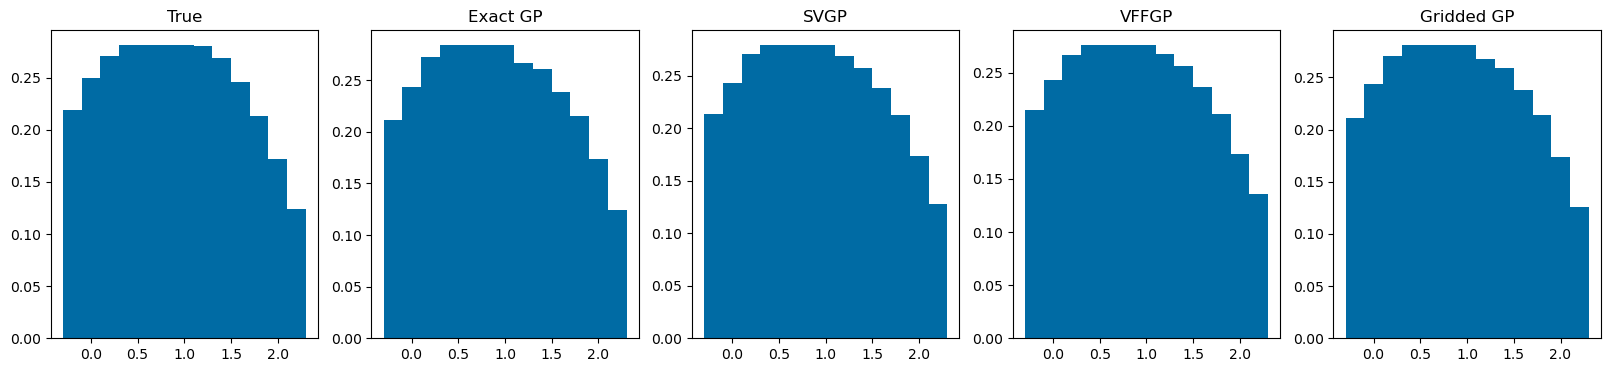

In [127]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))

# plot true
ax1.bar(midpoints, y_true)
ax1.set_title('True')

# plot exat GP
ax2.bar(midpoints, exactgp_grid_pred.mean.detach().numpy())
ax2.set_title('Exact GP')

# plot SVGP
ax3.bar(midpoints, svgp_grid_pred.mean.detach().numpy())
ax3.set_title('SVGP')

# plot VFFGP
ax4.bar(midpoints, vffgp_grid_pred.mean.detach().numpy())
ax4.set_title('VFFGP')

# plot Gridded GP (Mine)
ax5.bar(midpoints, griddedgp_grid_pred.mean.detach().numpy())
ax5.set_title('Gridded GP')